In [179]:
import re
import random
import requests
from requests.exceptions import RequestException
from datetime import datetime, timedelta
from typing import List, Optional

import pandas as pd
import matplotlib.pyplot as plt

from alibi_detect.od import SpectralResidual

In [195]:
def iso_to_datetime(iso_string) -> Optional[datetime]:
    '''Converts a string showing a timestamp in ISO 8601 format into a datetime object'''
    try:
        dt = datetime.fromisoformat(iso_string).replace(tzinfo=None)
        return dt
    except ValueError:
        return None
        
def get_measurements_past(
    uuid: str,
    window=str,
    older_than_one_day: bool = True
) -> Optional[pd.DataFrame]:
    '''Get the water level measurements for the requested window and the selected uuid (station). 
       The final measurements are the ones that are at least 15 minutes old.
    
    Parameters
    ==========
    uuid: The uuid of the station for which the measurements should be fetched
    window: Time window in the past to fetch the measurements. It follows one of
            PINTD or PTINTM or PTINTH formats. For example, P2D (past 2 days) or 
            PT10H (past 10 hours).
    older_than_one_day: Whether to keep measurements that are older than one day

    Returns
    =======
    None if there are no measurements or a list of dictionaries, otherwise. 
    The dictionaries has two keys; 'timestamp' and 'value'.  
    '''
    PATTERN = r'^P(\d+D|T(\d+H|\d+M))$'

    assert bool(re.match(PATTERN, window)), \
        'window should follow one of PINTD or PTINTM or PTINTH formats'
    
    res = requests.get('https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations' \
        f'/{uuid}/W/measurements.json?start={window}')
    
    if res.status_code == 200:
        rows = []
        measurements = res.json()
        if measurements:
            for measurement in measurements:
                measurement['timestamp'] = \
                    iso_to_datetime(measurement['timestamp'])
                measurement['uuid'] = uuid
                rows.append(measurement)
            df = pd.DataFrame(rows)
            if older_than_one_day:
                df = df[df['timestamp'] < (datetime.now() - timedelta(days=1))] 
            return df.sort_values('timestamp')
        else:
            return None
    else:
        raise RequestException

def get_pandas_count_null(df: pd.DataFrame) -> pd.Series:   
    return df.isna().sum()

In [196]:
# Get stations uuid
res = requests.get(f'https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations.json')
stations_uuid = [station['uuid'] for station in res.json()]
# Take a sample of size 10 (without replacement) from the stations 
sampled_uuids = random.sample(stations_uuid, 10)

In [197]:
list_of_dfs = []
# Number of stations for which the request for collection failed
failed_calls = 0

for station_uuid in sampled_uuids:
    # Get the measurements for the past 30 days for each uuid in the sample
    try:
        station_past_30days_df = get_measurements_past(station_uuid, 'P30D', older_than_one_day=False)
        # If there are no records
        if station_past_30days_df is None:
            continue
        else:
            list_of_dfs.append(station_past_30days_df)
    # If the request fails
    except RequestException:
        failed_calls += 1
        continue

df_all_sampled_stations = pd.concat(list_of_dfs, axis=0, ignore_index=True) 
print('Number of stations with a failed request: {}'.format(failed_calls))
    

Number of stations with a failed request: 0


In [198]:
df = pd.DataFrame(pandas_data)

In [201]:
assert get_pandas_count_null(df).sum() == 0, 'Some columns include NAN values'

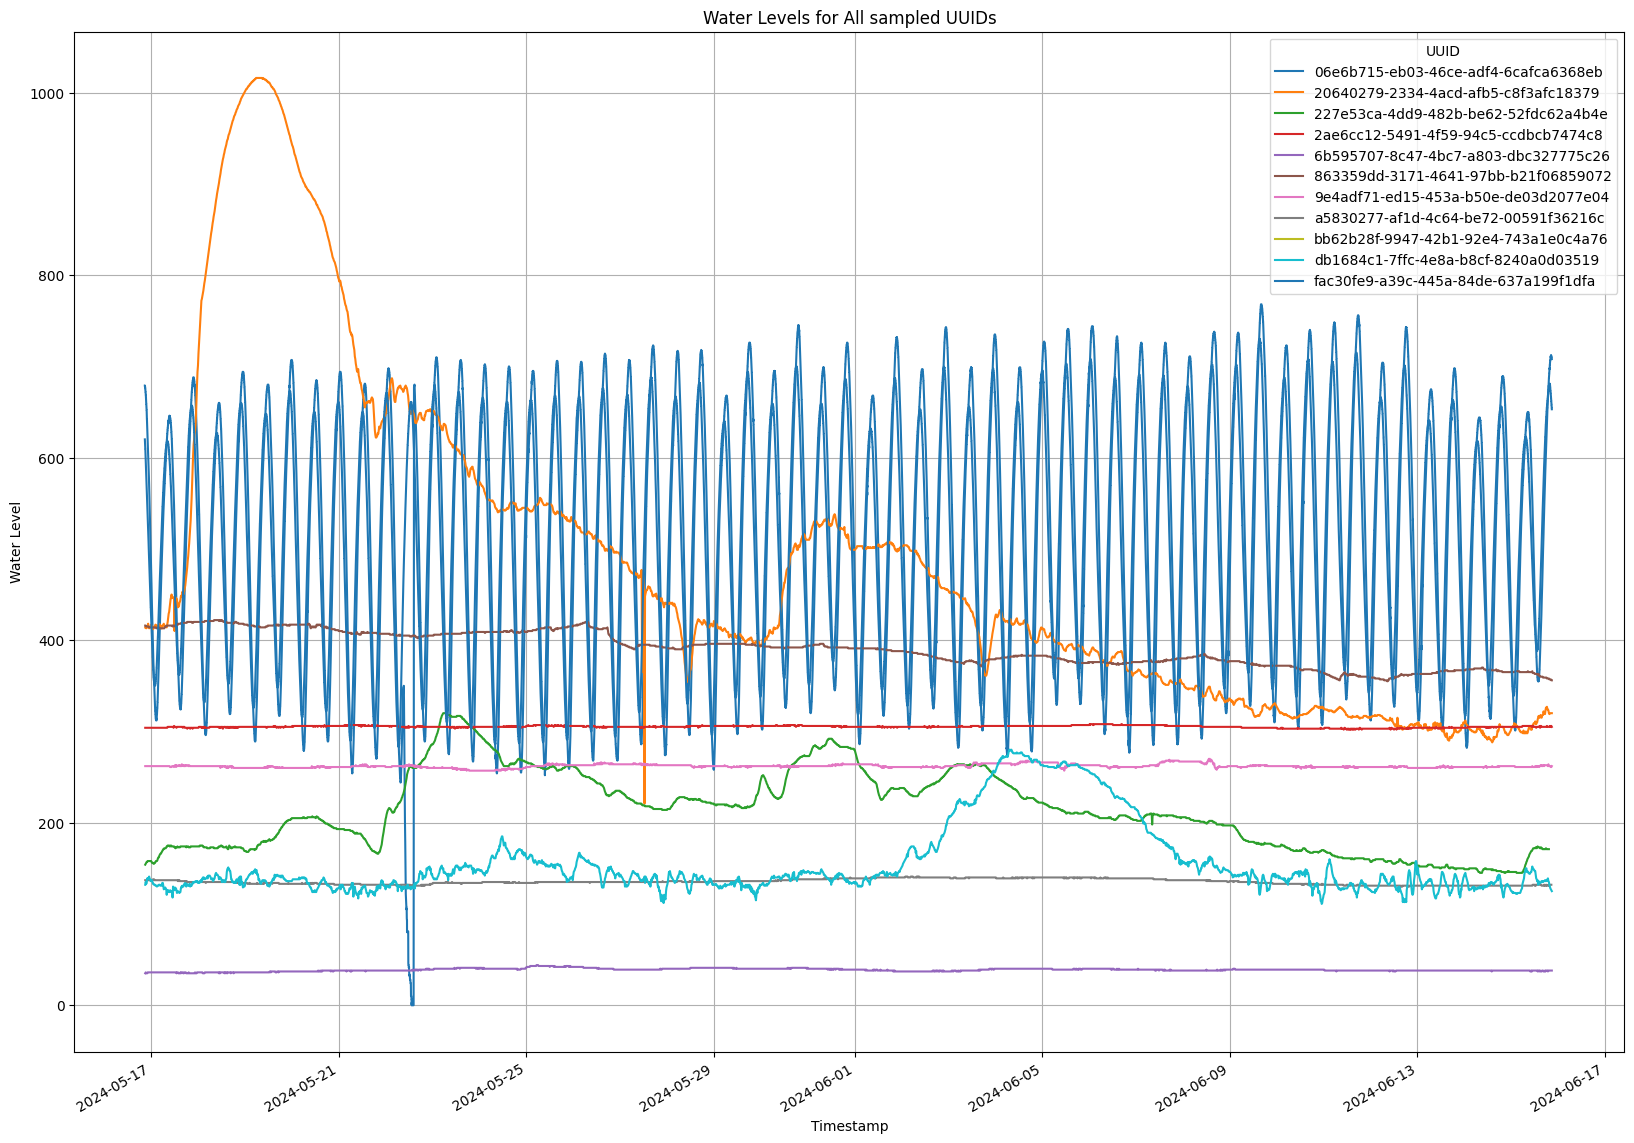

In [202]:
fig, ax = plt.subplots(figsize=(20, 15))

for uuid, group in df.groupby('uuid'):
    group.plot(x='timestamp', y='value', label=uuid, ax=ax)

plt.xlabel('Timestamp')
plt.ylabel('Water Level')
plt.title('Water Levels for All sampled UUIDs')
plt.legend(title='UUID')
plt.grid(True)
plt.show()

In [203]:
# Unique uuid for stations
unique_uuids = df.uuid.unique()

In [211]:
station_uuid

'20640279-2334-4acd-afb5-c8f3afc18379'

Estimating the threshold for SpectralResidual ...
SpectralResidual threshold updated successfully! New threshold is -0.9698641631406161.
Performing anomaly detection on new measurements ...
Detection is done! Creating the plot ...


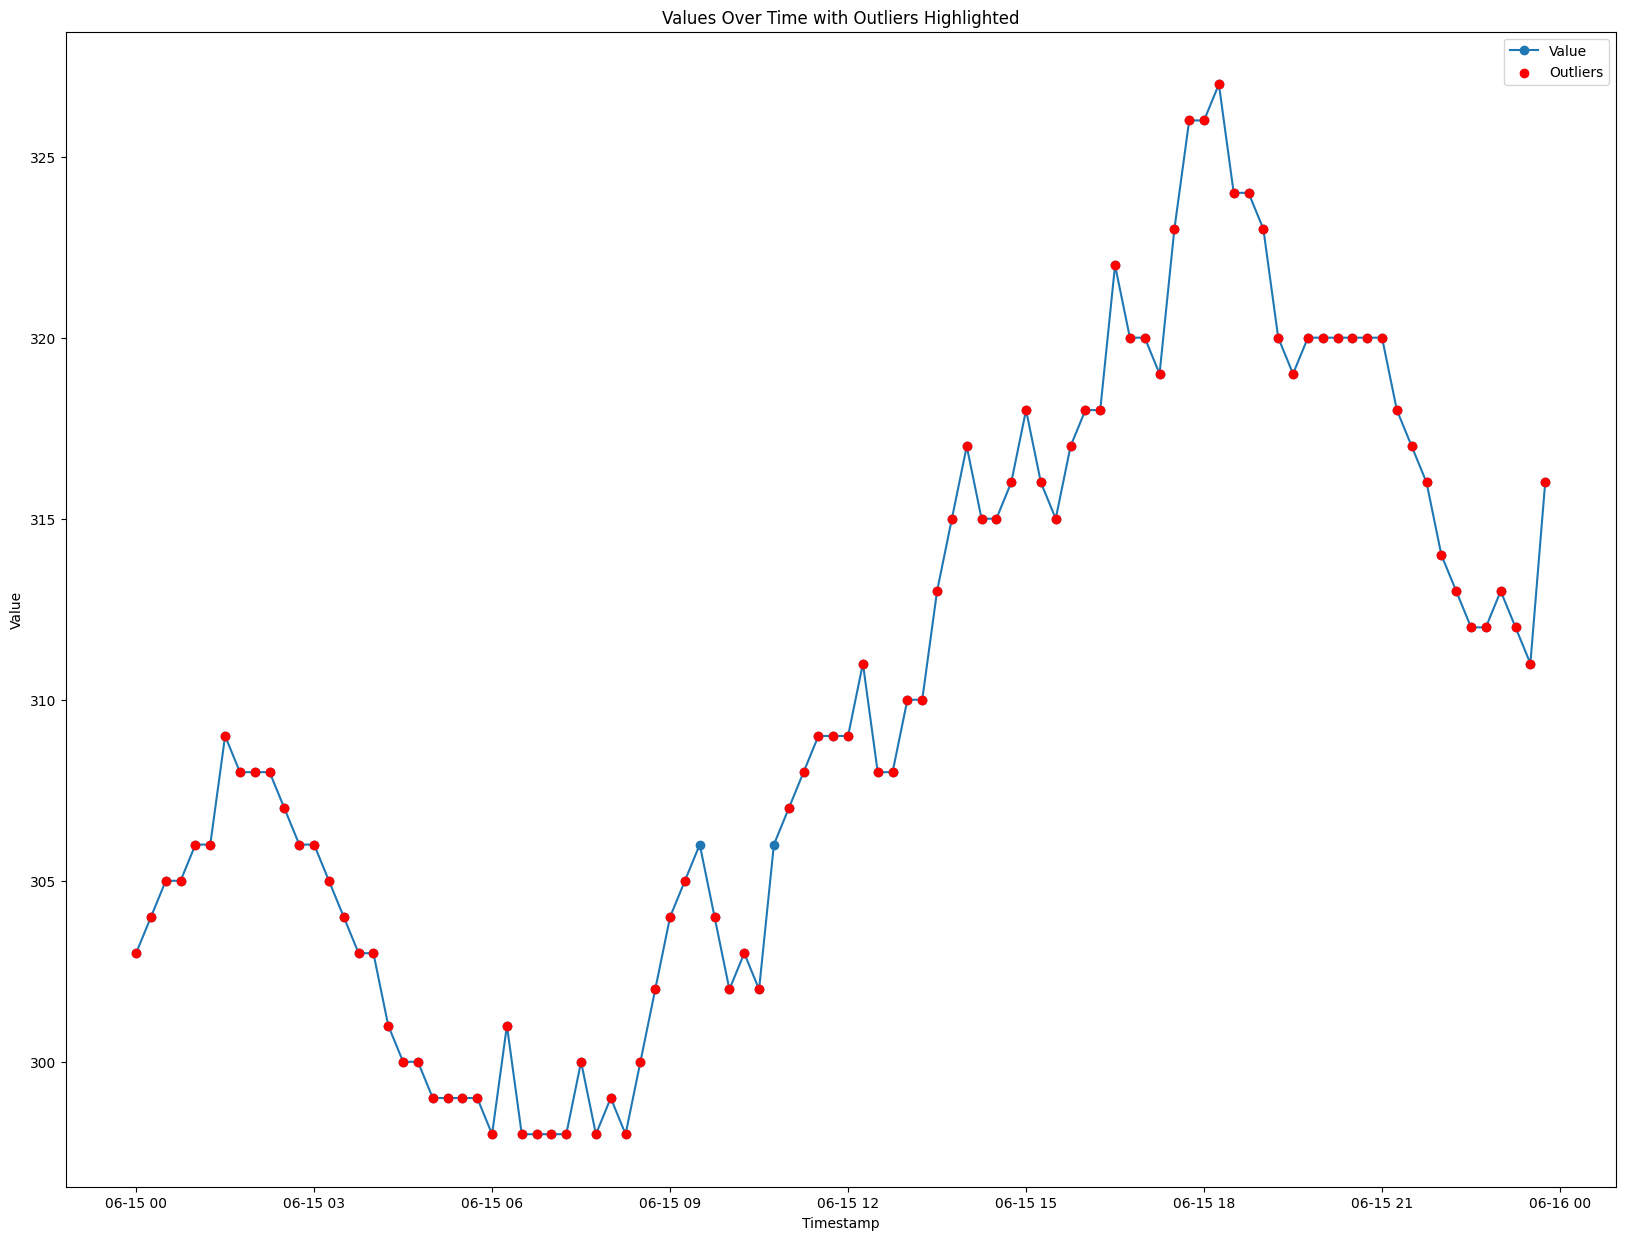

In [216]:
station_uuid = unique_uuids[7]

DETECTION_WINDOW = 'P1D'
THRESHOLD_WINDOW = 'P8D'

try:
    df_threshold = get_measurements_past(uuid=station_uuid, window=THRESHOLD_WINDOW)
    if df_threshold is None:
        print('Historized measurements for this station are not available')
    else:
        print('Estimating the threshold for SpectralResidual ...')
        # Initialization
        od = SpectralResidual(
            threshold=1.,
            window_amp=20,
            window_local=20,
            padding_amp_method='reflect',
            padding_local_method='reflect',
            padding_amp_side='bilateral',
            n_est_points=10,
            n_grad_points=5
        )
        # Update the threshold
        od.infer_threshold(df_threshold.value.values, threshold_perc=0.95)
        print('SpectralResidual threshold updated successfully! New threshold is {}.'.format(od.threshold))
        try:
            df_detection = get_measurements_past(uuid=station_uuid, window=DETECTION_WINDOW, older_than_one_day=False)
            if df_detection is None:
                print('No new measurements are available for the selected backward window')
            else:
                print('Performing anomaly detection on new measurements ...')
                preds = od.predict(df_detection.value.values, return_instance_score=True)
                print('Detection is done! Creating the plot ...')
                
                plt.figure(figsize=(20, 15))
                plt.plot(df_detection['timestamp'], df_detection['value'], label='Value', marker='o')

                outliers = df_detection[preds['data']['is_outlier'] == 1]
                plt.scatter(outliers['timestamp'], outliers['value'], color='red', label='Outliers', zorder=4)

                plt.title('Values Over Time with Outliers Highlighted')
                plt.xlabel('Timestamp')
                plt.ylabel('Value')
                plt.legend()

                plt.show()
        except RequestException:
            print('Request to get the measuremnets for detection failed')

except RequestException:
    print('Anomaly detection cannot be done for this station (uuid: {})'.format(station_uuid))    